In [1]:
import numpy as np
from gurobipy import *
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
path_wind = '/Users/simgecinar/Desktop/Github/Energy-Systems-Planning-Project/data/wind/'
wind1 = pd.read_csv(path_wind+'jan.csv', header = None)
wind2 = pd.read_csv(path_wind+'feb.csv', header = None)
wind3 = pd.read_csv(path_wind+'march.csv', header = None)
wind4 = pd.read_csv(path_wind+'apr.csv', header = None)
wind5 = pd.read_csv(path_wind+'may.csv', header = None)
wind6 = pd.read_csv(path_wind+'june.csv', header = None)
wind7 = pd.read_csv(path_wind+'july.csv', header = None)
wind8 = pd.read_csv(path_wind+'aug.csv', header = None)
wind9 = pd.read_csv(path_wind+'sep.csv', header = None)
wind10 = pd.read_csv(path_wind+'oct.csv', header = None)
wind11 = pd.read_csv(path_wind+'nov.csv', header = None)
wind12 = pd.read_csv(path_wind+'dec.csv', header = None)

In [3]:
path_solar = '/Users/simgecinar/Desktop/Github/Energy-Systems-Planning-Project/data/solar/'
solar1 = pd.read_csv(path_solar+'jan.csv', header = None)
solar2 = pd.read_csv(path_solar+'feb.csv', header = None)
solar3 = pd.read_csv(path_solar+'march.csv', header = None)
solar4 = pd.read_csv(path_solar+'apr.csv', header = None)
solar5 = pd.read_csv(path_solar+'may.csv', header = None)
solar6 = pd.read_csv(path_solar+'june.csv', header = None)
solar7 = pd.read_csv(path_solar+'july.csv', header = None)
solar8 = pd.read_csv(path_solar+'aug.csv', header = None)
solar9 = pd.read_csv(path_solar+'sep.csv', header = None)
solar10 = pd.read_csv(path_solar+'oct.csv', header = None)
solar11 = pd.read_csv(path_solar+'nov.csv', header = None)
solar12 = pd.read_csv(path_solar+'dec.csv', header = None)

In [4]:
path_demand = '/Users/simgecinar/Desktop/Github/Energy-Systems-Planning-Project/data/demand/'
demand1 = pd.read_csv(path_demand+'jan.csv', header = None)
demand2 = pd.read_csv(path_demand+'feb.csv', header = None)
demand3 = pd.read_csv(path_demand+'march.csv', header = None)
demand4 = pd.read_csv(path_demand+'apr.csv', header = None)
demand5 = pd.read_csv(path_demand+'may.csv', header = None)
demand6 = pd.read_csv(path_demand+'june.csv', header = None)
demand7 = pd.read_csv(path_demand+'july.csv', header = None)
demand8 = pd.read_csv(path_demand+'aug.csv', header = None)
demand9 = pd.read_csv(path_demand+'sep.csv', header = None)
demand10 = pd.read_csv(path_demand+'oct.csv', header = None)
demand11 = pd.read_csv(path_demand+'nov.csv', header = None)
demand12 = pd.read_csv(path_demand+'dec.csv', header = None)

In [5]:
def optimization(w, s, d):
    wind_listt = [item for sublist in w.values.tolist() for item in sublist]
    area = 200
    wind_listt2 = [0.63*area*(x**3) for x in wind_listt]
    wind_listt3 = [(14.4/60000)*x for x in wind_listt2]

    solar_listt = [item for sublist in s.values.tolist() for item in sublist]
    solar_listt2 = [1.55*x for x in solar_listt]

    demand_listt = [item for sublist in d.values.tolist() for item in sublist]
    demand_listt2 = [0.7*x for x in demand_listt]

    #INDEX
    T = [i for i in range(0,len(solar_listt))]

    #PARAMETERS
    C_W = 0.095*(len(solar_listt)/100) #For now, unit operating and maintenance cost of a wind turbine (euro/kw) = bölüm 100 to find the corresponding value for 14.4 min.
    C_PV = 0.052*(len(solar_listt)/100)  #Unit operating and maintenance cost of a PV panel (euro/kw) = divide by 100 to find the corresponding value for 14.4 min.
    C_network = 0.18*(14.4/60) #Unit cost of purchased energy, independent of the time interval (euro/ kwh)

    P_W = wind_listt3 # Wind-turbine power production in the i-th interval.
    P_PV = solar_listt2 #PV power production in the i-th interval.
    P_load = demand_listt2 #Load power demand in the i-th interval.

    m = 1440 #number of minutes in a day.
    N = 100 #time intervals, which is chosen by the authors.

    B = 300000 #Fixed budget 
    C_Winst = 6500 #Unit installation cost of wind turbine.
    C_Pinst = 200 #Unit installation cost of PV.

    A_b = 5 #Basic ground area occupied by a wind turbine.
    A_max = 15 #Available area for wind power plant (in m^2)

    #Calculation for the installation of PV panels and reducing the shading and allowing corridors.
    S_l = 1600
    s_l = 5
    L = 0.982
    cos16 = 0.96126169593
    tan16 = 0.28674538575
    tan24 = 0.4452286853
    Geo = ((S_l-3)*(s_l-3))/(L**2*cos16*(1+(tan16/tan24)))
    #print("Max area for solar:", Geo)

    mdl = Model("Energy Model")

    #DECISION VARIABLES
    W = mdl.addVar(lb=0.0, vtype = GRB.INTEGER, name ="W") #Number of wind turbines.
    P = mdl.addVar(lb = 0.0, vtype= GRB.INTEGER, name = "P") #Number of PV panels.
    X = mdl.addVars(T, lb= 0.0, vtype=GRB.CONTINUOUS, name="X") #Energy purchased from the network at each interval.

    P_pvd = mdl.addVars(T, lb=0.0, vtype = GRB.CONTINUOUS, name= "P_pvd") #Generated PV to demand point.
    P_pvc = mdl.addVars(T, lb=0.0, vtype = GRB.CONTINUOUS, name= "P_pvc") #Generated PV to be curtailed.
    W_wd = mdl.addVars(T, lb=0.0, vtype = GRB.CONTINUOUS, name= "W_wd") #Generated wind to demand point.
    W_wc = mdl.addVars(T, lb=0.0, vtype = GRB.CONTINUOUS, name= "W_wc") #Generated wind to be curtailed.

    #OBJECTIVE FUNCTION
    mdl.modelSense = GRB.MINIMIZE
    mdl.setObjective(C_W*W*5 + C_PV*P*0.22 + quicksum(C_network*X[i] for i in T))

    #CONSTRAINTS
    #1
    mdl.addConstrs(((P_pvd[i]+ W_wd[i]) + X[i] == P_load[i] for i in T))

    #2
    mdl.addConstrs(P_W[i]*W == P_pvd[i] + P_pvc[i] for i in T)

    #3
    mdl.addConstrs(P_PV[i]*P == W_wd[i] + W_wc[i] for i in T)

    #4 (Initial cost of wind turbines and PV does not exceed the fixed budget)
    mdl.addConstr(C_Winst*W + C_Pinst*P <= B)

    #5 (Area occupied by a wind turbine does not exceeding available area)
    mdl.addConstr(W*A_b <= A_max)

    #6 (Area constraint for PV panels)
    mdl.addConstr(P <= Geo)

    mdl.optimize()

    solution = []
    for v in mdl.getVars():
        solution.append(v.X)
    return solution

In [6]:
l1 = [wind1, wind2, wind3, wind4, wind5, wind6, wind7, wind8, wind9, wind10, wind11, wind12]
l2 = [solar1, solar2, solar3, solar4, solar5, solar6, solar7, solar8, solar9, solar10, solar11, solar12]
l3 = [demand1, demand2, demand3, demand4, demand5, demand6, demand7, demand8, demand9, demand10, demand11, demand12]

w = []
s = []
purchase_max = []
purchase_sum = []
for i in range(12):
    solution = optimization(l1[i], l2[i], l3[i])
    w.append(solution[0])
    s.append(solution[1])
    purchase = solution[2:]
    purchase_max.append(max(purchase))
    purchase_sum.append(sum([i for i in purchase]))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-10
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9303 rows, 15502 columns and 24804 nonzeros
Model fingerprint: 0x87b88251
Variable types: 15500 continuous, 2 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-10, 6e+03]
  Objective range  [4e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 9303 rows and 15502 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.01 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 2238.77 2238.77 

Optimal solution found (tolerance 

Model fingerprint: 0x29c19982
Variable types: 15500 continuous, 2 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-12, 6e+03]
  Objective range  [4e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 6678 rows and 13390 columns
Presolve time: 0.02s
Presolved: 2625 rows, 2112 columns, 5610 nonzeros
Variable types: 2110 continuous, 2 integer (0 binary)
Found heuristic solution: objective 2082.1028053

Root relaxation: objective 1.814027e+03, 1109 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1814.02668    0    1 2082.10281 1814.02668  12.9%     -    0s
H    0     0                    1814.0275492 1814.02668  0.00%     -    0s

Explored 1 nodes (1109 simplex iter

Best objective 1.931005622359e+03, best bound 1.931005622359e+03, gap 0.0000%


In [7]:
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
colname = ['# of wind turbine', '# of PV panel', 'Max of purchased energy', 'Total purchased energy']
df = pd.DataFrame(index = month, columns=colname)
df['# of wind turbine'] = w
df['# of PV panel'] = s
df['Max of purchased energy'] = purchase_max
df['Total purchased energy'] = purchase_sum
df

,# of wind turbine,# of PV panel,Max of purchased energy,Total purchased energy
January,3.0,-0.0,61.639886,83662.291567
February,3.0,-0.0,55.292611,76095.455538
March,3.0,-0.0,40.944466,80029.613012
April,3.0,413.0,70.364568,88363.718476
May,3.0,426.0,83.457703,105496.493826
June,3.0,385.0,66.559307,93920.811735
July,3.0,395.0,73.660213,98198.787698
August,3.0,486.0,85.120983,106289.893175
September,3.0,513.0,81.726217,89803.122707
October,3.0,409.0,57.990020,88125.761110


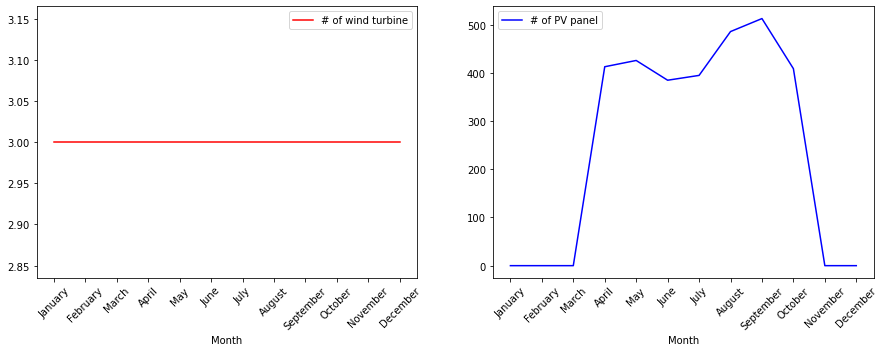

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(month, w, color = 'red', label = '# of wind turbine')
plt.legend(loc="best")
plt.xlabel('Month')
plt.xticks(rotation = 45)

plt.subplot(1, 2, 2)
plt.plot(month, s, color = 'blue', label = '# of PV panel')
plt.legend(loc="best")
plt.xlabel('Month')
plt.xticks(rotation = 45)

plt.show()

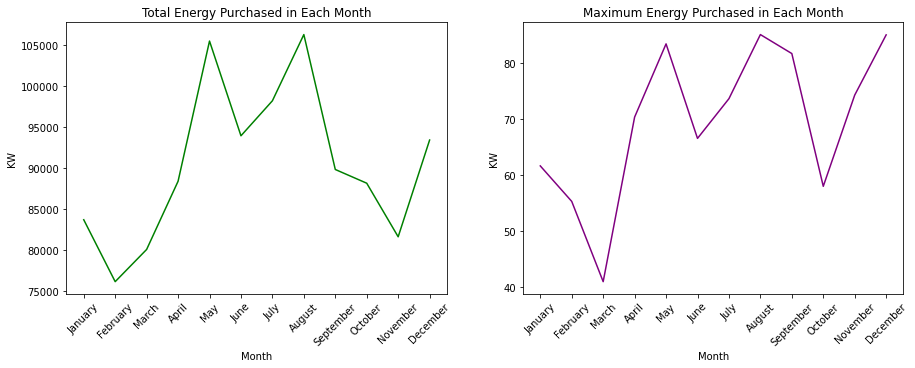

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(month, purchase_sum, color = 'green')
plt.title('Total Energy Purchased in Each Month')
plt.xlabel('Month')
plt.xticks(rotation = 45)
plt.ylabel('KW')

plt.subplot(1, 2, 2)
plt.plot(month, purchase_max, color = 'purple')
plt.title('Maximum Energy Purchased in Each Month')
plt.xlabel('Month')
plt.xticks(rotation = 45)
plt.ylabel('KW')

plt.show()